# 1. Further CRE analysis

These first few cells are just meant to get an overview of the files created in the previous jupyter notebook (CRE_location_and_expression_correlation.ipynb)

In [3]:
import pandas as pd
anno = pd.read_csv("peak_to_gene_annotated.csv")
print("Annotation columns:", anno.columns.tolist())


Annotation columns: ['peak_id', 'chrom', 'peak_center', 'start', 'end', 'gene_symbol', 'tss', 'strand', 'signed_distance_to_tss', 'distance_to_tss']


In [4]:
gene_map = pd.read_csv("gene_regulatory_map.csv")

gene_map.head()

,gene_symbol,Region,peak_id,spearman_rho,signed_distance_to_tss
0,0610005C13Rik,Distal Upstream,"['ImmGenATAC1219.peak_427236', 'ImmGenATAC1219...","[-0.238722441512202, -0.1735676353173739, -0.3...","[-14074, -14334, -15928, -16780, -17125, -1811..."
1,0610005C13Rik,Proximal Downstream,"['ImmGenATAC1219.peak_427235', 'ImmGenATAC1219...","[0.1867547187476273, 0.1867547187476273, 0.186...","[1003, 1003, 1003, 1003, 1003, 1003, 1003, 100..."
2,0610009B22Rik,Distal Downstream,"['ImmGenATAC1219.peak_75283', 'ImmGenATAC1219....","[-0.0049301577859799, 0.041506723580693, 0.288...","[17046, 14331, 10788, 17046, 14331, 10788, 170..."
3,0610009B22Rik,Distal Upstream,"['ImmGenATAC1219.peak_75292', 'ImmGenATAC1219....","[-0.0576371269475148, -0.1177606246713551, -0....","[-14432, -14889, -15224, -14432, -14889, -1522..."
4,0610009B22Rik,Promoter,"['ImmGenATAC1219.peak_75288', 'ImmGenATAC1219....","[0.1713425498459762, 0.4176245210727969, 0.542...","[214, -163, -479, 214, -163, -479, 214, -163, ..."


In [5]:
all_gene_cor = pd.read_csv("all_peak_gene_correlations.csv")

all_gene_cor.head()


,peak_id,gene_symbol,signed_distance_to_tss,spearman_rho,pval
0,ImmGenATAC1219.peak_40,Rp1,90921,0.366699,0.054935
1,ImmGenATAC1219.peak_41,Rp1,82495,0.201068,0.304905
2,ImmGenATAC1219.peak_42,Rp1,79777,0.501165,0.006594
3,ImmGenATAC1219.peak_43,Rp1,76586,-0.205367,0.294463
4,ImmGenATAC1219.peak_44,Rp1,63686,0.308451,0.110272


In [6]:
import pandas as pd
import matplotlib.pyplot as plt
import ast

# turning the text‐lists back into Python lists
gene_map["peak_list"] = gene_map["peak_id"].apply(ast.literal_eval)
# adding a column for the number of peaks per gene‐region
gene_map["n_peaks"] = gene_map["peak_list"].apply(len)


### Where are most CREs located?

Analysis and plotting

### CREs per Region ###
                     Unique_CREs  Percent
Region                                   
Distal Downstream          35374     10.8
Proximal Downstream        45011     13.7
Promoter                   42078     12.8
Proximal Upstream          32596      9.9
Distal Upstream            23674      7.2
Unassigned                150066     45.6


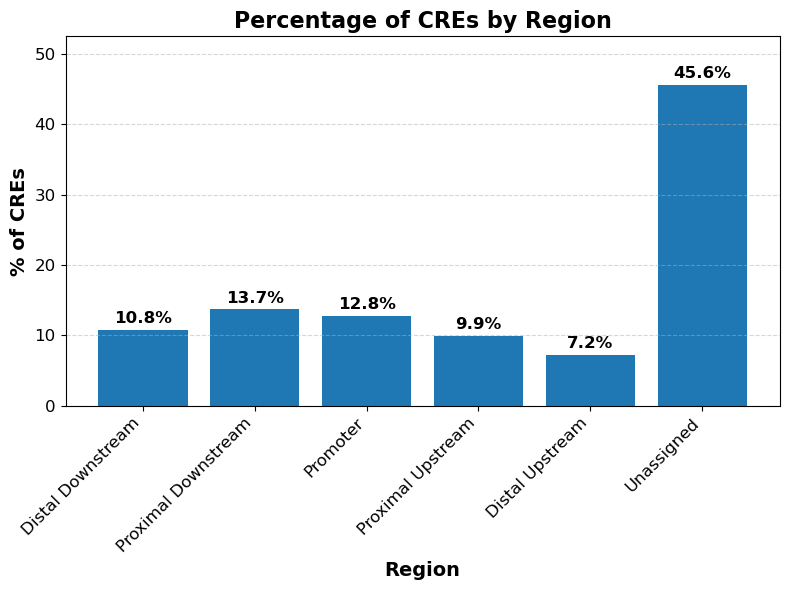

In [7]:
# explode so each row is one peak–gene link
exploded = gene_map.explode("peak_list")

# drop duplicates so each peak only counted once per region
exploded_unique = exploded.drop_duplicates(subset=["Region","peak_list"])

# count unique peaks by Region
unique_counts = exploded_unique.groupby("Region")["peak_list"].count()
unique_perc   = unique_counts / unique_counts.sum() * 100

# define the desired order
order = [
    "Distal Downstream",
    "Proximal Downstream",
    "Promoter",
    "Proximal Upstream",
    "Distal Upstream",
    "Unassigned"
]

# reindexing to enforce order
unique_perc = unique_perc.reindex(order).fillna(0)

# printing stats
unique_stats = pd.DataFrame({
    "Unique_CREs": unique_counts.reindex(order).fillna(0).astype(int),
    "Percent":     unique_perc.round(1)
})
print("### CREs per Region ###")
print(unique_stats)

# plotting

fig, ax = plt.subplots(figsize=(8, 6))

bars = ax.bar(unique_perc.index, unique_perc.values)

ax.set_title("Percentage of CREs by Region", fontweight="bold", fontsize=16)
ax.set_xlabel("Region",                  fontweight="bold", fontsize=14)
ax.set_ylabel("% of CREs",               fontweight="bold", fontsize=14)

plt.xticks(rotation=45, ha="right", fontsize=12)
ax.tick_params(axis="y", labelsize=12)

ymax = unique_perc.values.max() * 1.15
ax.set_ylim(0, ymax)

ax.yaxis.grid(True, linestyle="--", alpha=0.5)

for bar in bars:
    height = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        height + ymax * 0.01,
        f"{height:.1f}%",
        ha="center", va="bottom",
        fontweight="bold", fontsize=12
    )

plt.tight_layout()
plt.show()



### **2.iii.c.** 

How many CREs are associated with each gene?

- Summary of the distribution and flagging genes with unusually high numbers of associated CREs.

In [8]:
# Sum across regions to get total CREs per gene
total_cres = gene_map.groupby("gene_symbol")["n_peaks"].sum()

# Summary statistics
desc      = total_cres.describe()
q1, q3    = desc["25%"], desc["75%"]
iqr       = q3 - q1
threshold = q3 + 1.5 * iqr

print("### CREs per Gene Summary ###")
print(desc.round(1))
print(f"\nOutlier threshold (Q3 + 1.5·IQR): {threshold:.0f} CREs")

# Flagging genes above threshold
outliers = total_cres[total_cres > threshold].sort_values(ascending=False)
print(f"\n### Genes with >{threshold:.0f} CREs ###")
print(outliers)

### CREs per Gene Summary ###
count    16604.0
mean       574.3
std        551.0
min         29.0
25%        203.0
50%        406.0
75%        754.0
max       4930.0
Name: n_peaks, dtype: float64

Outlier threshold (Q3 + 1.5·IQR): 1580 CREs

### Genes with >1580 CREs ###
gene_symbol
Pisd-ps3    4930
Tns3        4408
Mbnl1       4350
Pde4b       4205
Nck2        4118
            ... 
Elf1        1595
Esr1        1595
Fbxw7       1595
Ago2        1595
Adam6b      1595
Name: n_peaks, Length: 1042, dtype: int64


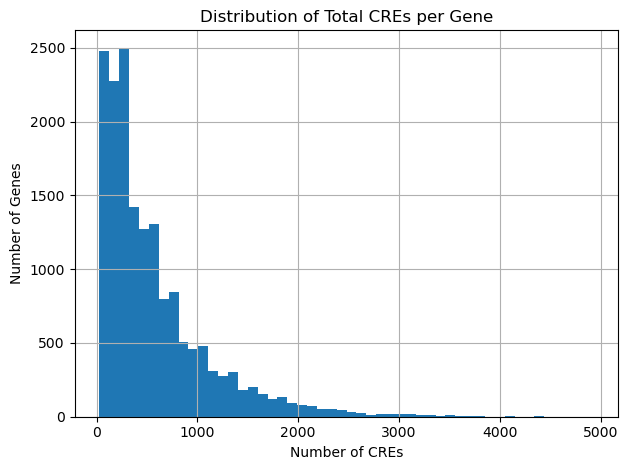

In [9]:
# Histogram of CRE counts
import matplotlib.pyplot as plt

plt.figure()
total_cres.hist(bins=50)
plt.title("Distribution of Total CREs per Gene")
plt.xlabel("Number of CREs")
plt.ylabel("Number of Genes")
plt.tight_layout()
plt.show()


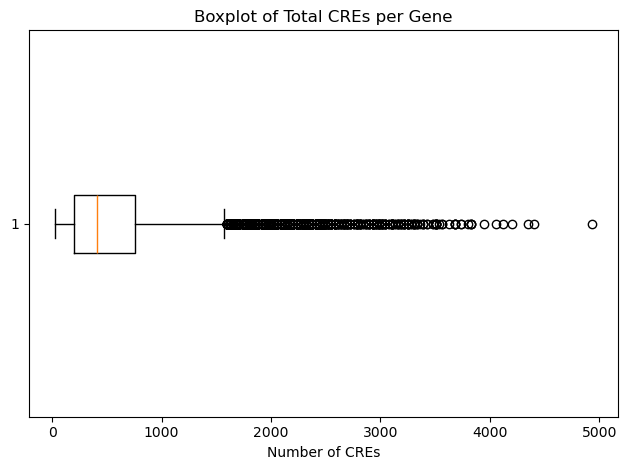

In [10]:
# Boxplot of CRE counts
plt.figure()
plt.boxplot(total_cres.values, vert=False)
plt.title("Boxplot of Total CREs per Gene")
plt.xlabel("Number of CREs")
plt.tight_layout()
plt.show()


In [11]:
# Cell 7: List genes with >2000 CREs
high_cres = total_cres[total_cres > 2000].sort_values(ascending=False)

print(f"Found {len(high_cres)} genes with >2000 CREs:\n")
print(high_cres.to_string())

#Save to CSV for downstream inspection
high_cres.to_frame(name="n_CREs").to_csv("genes_over_2000_CREs.csv")


Found 503 genes with >2000 CREs:

gene_symbol
Pisd-ps3         4930
Tns3             4408
Mbnl1            4350
Pde4b            4205
Nck2             4118
Etv6             4060
Rin3             3944
Ets1             3828
Fam107b          3828
Ywhaz            3828
Med13l           3799
B3gnt2           3741
Tbl1xr1          3741
Fli1             3683
Sik1             3683
Bach1            3683
Sgms1            3683
Rybp             3625
Irf2bp2          3567
Plxnc1           3567
Hdac4            3538
Pag1             3509
Pik3r1           3509
Mbnl2            3509
Iqgap2           3509
Hpcal1           3509
Bcor             3509
Lrrc8d           3480
9430078K24Rik    3480
Aebp2            3422
Trib1            3422
Btg1             3393
Irf4             3393
Runx3            3393
Myo10            3364
Bcl11b           3335
Ankrd44          3335
Atp2b1           3335
Elmo1            3306
Sash1            3306
Bcl2l11          3306
Daam1            3306
S1pr1            3306
4930459C

In [16]:
# (Re‐define or import your assign_region function if not already in scope)
def assign_region(d):
    if -1000 <= d <= 1000:
        return "Promoter"
    elif -10000 <= d < -1000:
        return "Proximal Upstream"
    elif  1000 < d <= 10000:
        return "Proximal Downstream"
    elif -20000 <= d < -10000:
        return "Distal Upstream"
    elif 10000 < d <= 20000:
        return "Distal Downstream"
    else:
        return "Unassigned"

# 2) Parse the stored lists
gene_map["peak_list"] = gene_map["peak_id"].apply(ast.literal_eval)
gene_map["dist_list"] = gene_map["signed_distance_to_tss"].apply(ast.literal_eval)
gene_map["n_peaks"]   = gene_map["peak_list"].apply(len)

# 3) Identify high‐CRE genes
total_cres = gene_map.groupby("gene_symbol")["n_peaks"].sum()
high_genes = total_cres[total_cres > 2000].index.tolist()

# 4) Filter to those genes and flatten distances
rows = []
for _, row in gene_map[gene_map["gene_symbol"].isin(high_genes)].iterrows():
    gene = row["gene_symbol"]
    for d in row["dist_list"]:
        rows.append({
            "gene_symbol":    gene,
            "distance_to_tss": d
        })

dist_df = pd.DataFrame(rows)

# 5) Assign regions
dist_df["Region"] = dist_df["distance_to_tss"].apply(assign_region)

# 6) Inspect & save
print(dist_df.head())
print(f"\nTotal distances collected: {len(dist_df)}")
dist_df.to_csv("high_CRE_gene_distances.csv", index=False)


     gene_symbol  distance_to_tss             Region
0  0610039H22Rik            10099  Distal Downstream
1  0610039H22Rik            10447  Distal Downstream
2  0610039H22Rik            12088  Distal Downstream
3  0610039H22Rik            12546  Distal Downstream
4  0610039H22Rik            12798  Distal Downstream

Total distances collected: 1268808


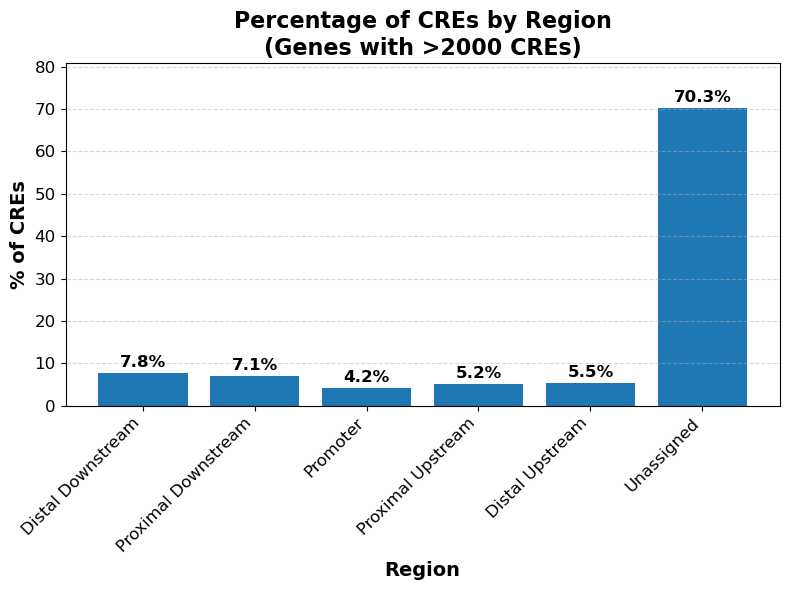

In [17]:
#% of CREs by Region for high‐CRE genes

import pandas as pd
import matplotlib.pyplot as plt

# Load the pre‐annotated distances
dist_df = pd.read_csv("high_CRE_gene_distances.csv")

# Compute counts & percentages in your predefined order
counts = dist_df["Region"].value_counts().reindex(order).fillna(0)
perc   = counts / counts.sum() * 100

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
bars = ax.bar(perc.index, perc.values)

ax.set_title("Percentage of CREs by Region\n(Genes with >2000 CREs)", 
             fontweight="bold", fontsize=16)
ax.set_xlabel("Region",       fontweight="bold", fontsize=14)
ax.set_ylabel("% of CREs",    fontweight="bold", fontsize=14)

# Ticks & grid
plt.xticks(rotation=45, ha="right", fontsize=12)
ax.tick_params(axis="y", labelsize=12)
ax.set_ylim(0, perc.max() * 1.15)
ax.yaxis.grid(True, linestyle="--", alpha=0.5)

# Annotate bars
for bar in bars:
    h = bar.get_height()
    ax.text(
        bar.get_x() + bar.get_width() / 2,
        h + perc.max() * 0.01,
        f"{h:.1f}%",
        ha="center", va="bottom",
        fontweight="bold", fontsize=12
    )

plt.tight_layout()
plt.show()


In [14]:
dist_df.head()

,gene_symbol,distance_to_tss
0,0610039H22Rik,10099
1,0610039H22Rik,10447
2,0610039H22Rik,12088
3,0610039H22Rik,12546
4,0610039H22Rik,12798
